the code should take in any spreadsheet under the format of the fire department
clean and prepare those columns 
select the columns 
put into a spreadsheet
then load that spreadsheet into the models 


    The purpose of this project is to create a  model which would allow a dispatcher to predict the alarm level of a call/event given certain parameters taken before the call is over and the issue is resolved. The assumptions of this project are that the columns chosen are based on parameters the dispatcher would take in and enter into a system GUI. 

    Based on these columns the data will be cleaned and prepared. Columns with unusable amounts of values (too many nulls which cannot be filled) will also be excluded. 

In [1]:
# libraries used

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.stats import norm

# transformations
import datetime as dt
import time
from sklearn import preprocessing

# sampling
from imblearn.over_sampling import SMOTE

# data prep
from sklearn.model_selection import train_test_split

In [2]:
# documents for preparation and training
fire_incidents = pd.read_csv('Incidents_Responded_to_by_Fire_Companies.csv')
fc2 = fire_incidents.copy()

/Users/oldvasegreenbird/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


    The two dataframes shown here were selected based on the number of viable rows available. 

    The first DataFrame: 'large_df' represents the largest DataFrame which was pulled together solely on keeping as many rows as possible (2456198) after extracting all null-rows. 

    The next DataFrame: 'medium_df' represents a medium number of rows (542921) which allowed us to extract as much data from the original dataset while preserving columns which could be helpful in training our model. 

    The last DataFrame: 'small_df' represents a small number of rows (10849) which preserved the least amount of our records but allowed us to keep as many columns as possible. 

In [3]:
# largest DataFrame
largerdf_columns = ['INCIDENT_TYPE_DESC', 'INCIDENT_DATE_TIME', 'HIGHEST_LEVEL_DESC',
 'PROPERTY_USE_DESC','ZIP_CODE', 'BOROUGH_DESC']
lrg_df = fc2[largerdf_columns]
large_df = lrg_df[lrg_df['HIGHEST_LEVEL_DESC'].notnull() & lrg_df['ZIP_CODE'].notnull() & lrg_df['PROPERTY_USE_DESC'].notnull()]

# medium DataFrame
RR_columns = ['FIRE_BOX','INCIDENT_TYPE_DESC','INCIDENT_DATE_TIME','HIGHEST_LEVEL_DESC', 'PROPERTY_USE_DESC',
              'STREET_HIGHWAY','ZIP_CODE','BOROUGH_DESC','FLOOR']
rr_c = fc2[RR_columns] 
medium_df = rr_c[rr_c['FLOOR'].notnull() & rr_c['BOROUGH_DESC'].notnull() & rr_c['ZIP_CODE'].notnull() 
                     & rr_c['FIRE_BOX'].notnull() & rr_c['STREET_HIGHWAY'].notnull() & rr_c['HIGHEST_LEVEL_DESC'].notnull()]

# smallest DataFrame
df_columns = ['FIRE_BOX','INCIDENT_TYPE_DESC','INCIDENT_DATE_TIME','HIGHEST_LEVEL_DESC', 'PROPERTY_USE_DESC',
              'STREET_HIGHWAY','ZIP_CODE','BOROUGH_DESC','FLOOR','STORY_FIRE_ORIGIN_COUNT','DETECTOR_PRESENCE_DESC','AES_PRESENCE_DESC','STANDPIPE_SYS_PRESENT_FLAG']
sm_df = fc2[df_columns]
small_df = sm_df[sm_df['FLOOR'].notnull() & sm_df['STANDPIPE_SYS_PRESENT_FLAG'].notnull() & sm_df['STREET_HIGHWAY'].notnull() 
                     & sm_df['STORY_FIRE_ORIGIN_COUNT'].notnull() & sm_df['AES_PRESENCE_DESC'].notnull() & sm_df['HIGHEST_LEVEL_DESC'].notnull()]


dfs = [large_df, medium_df, small_df]
df_names = ['Large DF','Medium DF', 'Small DF']


In [4]:
def return_non_nulls(df, df_str):
    ser_dict = {}
    for n,d in enumerate(df):
        ser_dict[df_str[n]] = d.notnull().sum().sort_values(ascending = False)
    comb_ser = pd.DataFrame.from_dict(ser_dict).reset_index().rename(columns={'index':'Column Name'}).sort_values(by='Large DF', ascending=False)
    print('Number of Non-Nulls per DataFrame per Column')
    return comb_ser


return_non_nulls(dfs, df_names)

Number of Non-Nulls per DataFrame per Column


,Column Name,Large DF,Medium DF,Small DF
1,BOROUGH_DESC,2518591.0,542921.0,10849
5,HIGHEST_LEVEL_DESC,2518591.0,542921.0,10849
6,INCIDENT_DATE_TIME,2518591.0,542921.0,10849
7,INCIDENT_TYPE_DESC,2518591.0,542921.0,10849
8,PROPERTY_USE_DESC,2518591.0,542921.0,10849
12,ZIP_CODE,2518591.0,542921.0,10849
0,AES_PRESENCE_DESC,NaN,NaN,10849
2,DETECTOR_PRESENCE_DESC,NaN,NaN,10849
3,FIRE_BOX,NaN,542921.0,10849
4,FLOOR,NaN,542921.0,10849


    There are a number of transformations to be done to the data before it is able to be used. Their descriptions are included before each cell with its code.

    Convert datetime columns which are currently object dtype into datetime format. In order to be able to use these in our model we must transform these columns into individual units such as: month, day. hour, minute. All three dataframes had the same column requiring this functional change. 

In [5]:
# transformations on datetime columns from object dtype
def datetime_columns_conversions(df, datetime_column_names):
    for d in df:
        d[datetime_column_names] = pd.to_datetime(d[datetime_column_names], infer_datetime_format=True)
        d['MONTH'] = d[datetime_column_names].apply(lambda x: x.month)
        d['DAY'] = d[datetime_column_names].apply(lambda x: x.day)
        d['HOUR'] = d[datetime_column_names].apply(lambda x: x.hour)
        d['MINUTE'] = d[datetime_column_names].apply(lambda x: x.minute)
        
datetime_columns_conversions(dfs, 'INCIDENT_DATE_TIME')

<ipython-input-5-570093dd505d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[datetime_column_names] = pd.to_datetime(d[datetime_column_names], infer_datetime_format=True)
<ipython-input-5-570093dd505d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['MONTH'] = d[datetime_column_names].apply(lambda x: x.month)
<ipython-input-5-570093dd505d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

    The cell below is a transformation on the 'HIGHEST_LEVEL_DESC' column representing the some of the different alarms the NYFD uses in their 10-Code system. These alarms are the most commonly used and also the only alarms included in the dataset. 

In [6]:
# this function will change all of the incorrectly labeled alarms 
def fix_alarms(x):
    if x == '1 - More than initial alarm, less than Signal 7-5':
        return 'More than first alarm, less than Signal 7-5'
    if x == '11 - First Alarm':
        return '1-1 First Alarm'
    if x == '7 - Signal 7-5' or x == '75 - All Hands Working':
        return '7-5 All Hands Working'
    if x == '2 - 2nd alarm' or x == '22 - Second Alarm':
        return '2-2 Second Alarm'
    if x == '3 - 3rd alarm' or x == '33 - Third Alarm':
        return '3-3 Third Alarm'
    if x == '4 - 4th alarm' or x == '44 - Fourth Alarm':
        return '4-4 Fourth Alarm'
    if x == '5 - 5th alarm' or x == '55 - Fifth Alarm':
        return '5-5 Fifth Alarm'
    if x == '0 - Initial alarm':
        return '1-1 First Alarm'
    
def apply_alarm_conversion(df, alarm_column):
    for d in df:
        d[alarm_column] = d[alarm_column].apply(lambda x: fix_alarms(x))
        
apply_alarm_conversion(dfs, 'HIGHEST_LEVEL_DESC')

<ipython-input-6-2d03cf8c7b77>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[alarm_column] = d[alarm_column].apply(lambda x: fix_alarms(x))


    The code below creates our 'Target Labels' column which we will use in our classifier models later on. The function also shows our spread of classes and we can see there is a significant imbalance. This requires correction and for this we will use the imblearn.oversampling 'SMOTE' package to balance these classes. Then we will sample the data for 500K rows with replacement. 

In [7]:
def create_target(df, column_to_target):
    """
    will create a target column from categorical / text data labels 
    """
    for n,d in enumerate(df):
        tc = preprocessing.LabelEncoder()
        tc.fit(d[column_to_target])
        d[column_to_target] = tc.transform(d[column_to_target])
    
    
create_target(dfs, 'HIGHEST_LEVEL_DESC')


<ipython-input-7-1e09fa8f494e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[column_to_target] = tc.transform(d[column_to_target])


In [8]:
print('\n',df_names[0],'\n', dfs[0].dtypes)


 Large DF 
 INCIDENT_TYPE_DESC            object
INCIDENT_DATE_TIME    datetime64[ns]
HIGHEST_LEVEL_DESC             int64
PROPERTY_USE_DESC             object
ZIP_CODE                      object
BOROUGH_DESC                  object
MONTH                          int64
DAY                            int64
HOUR                           int64
MINUTE                         int64
dtype: object


In [9]:
large_df['ZIP_CODE'].loc[226665, 5] = 11209
large_df['ZIP_CODE'] = large_df['ZIP_CODE'].astype('int64')

encoded_for_largedf = ['PROPERTY_USE_DESC', 'ZIP_CODE','INCIDENT_TYPE_DESC', 'BOROUGH_DESC']

def encode_column(df, column_to_encode):
    """
    will create a target column from categorical / text data labels 
    """
    tc = preprocessing.LabelEncoder()
    for ce in column_to_encode:
        tc.fit(df[ce])
        df[ce] = tc.transform(df[ce])
    
encode_column(large_df, encoded_for_largedf )


/Users/oldvasegreenbird/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-9-93a3ce618aa8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_df['ZIP_CODE'].loc[226665, 5] = 11209
<ipython-input-9-93a3ce618aa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
print('\n',df_names[1],'\n', dfs[1].dtypes)


 Medium DF 
 FIRE_BOX                      object
INCIDENT_TYPE_DESC            object
INCIDENT_DATE_TIME    datetime64[ns]
HIGHEST_LEVEL_DESC             int64
PROPERTY_USE_DESC             object
STREET_HIGHWAY                object
ZIP_CODE                      object
BOROUGH_DESC                  object
FLOOR                         object
MONTH                          int64
DAY                            int64
HOUR                           int64
MINUTE                         int64
dtype: object


In [11]:
medium_df['FIRE_BOX'] = medium_df['FIRE_BOX'].apply(lambda x: int(x))
medium_df['ZIP_CODE'] = medium_df['ZIP_CODE'].apply(lambda x: int(x))


<ipython-input-11-e98f123331d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_df['FIRE_BOX'] = medium_df['FIRE_BOX'].apply(lambda x: int(x))
<ipython-input-11-e98f123331d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_df['ZIP_CODE'] = medium_df['ZIP_CODE'].apply(lambda x: int(x))


In [12]:
encoded_for_mediumdf = ['FIRE_BOX', 'ZIP_CODE','BOROUGH_DESC',  'PROPERTY_USE_DESC','INCIDENT_TYPE_DESC', 'STREET_HIGHWAY','FLOOR']
encode_column(medium_df, encoded_for_mediumdf )

<ipython-input-9-93a3ce618aa8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ce] = tc.transform(df[ce])


In [13]:
print('\n',df_names[2],'\n', dfs[2].dtypes)


 Small DF 
 FIRE_BOX                              object
INCIDENT_TYPE_DESC                    object
INCIDENT_DATE_TIME            datetime64[ns]
HIGHEST_LEVEL_DESC                     int64
PROPERTY_USE_DESC                     object
STREET_HIGHWAY                        object
ZIP_CODE                              object
BOROUGH_DESC                          object
FLOOR                                 object
STORY_FIRE_ORIGIN_COUNT              float64
DETECTOR_PRESENCE_DESC                object
AES_PRESENCE_DESC                     object
STANDPIPE_SYS_PRESENT_FLAG           float64
MONTH                                  int64
DAY                                    int64
HOUR                                   int64
MINUTE                                 int64
dtype: object


In [14]:

small_df['FIRE_BOX'] = small_df['FIRE_BOX'].apply(lambda x: int(x))
small_df['ZIP_CODE'] = small_df['ZIP_CODE'].astype('int64')
# encoded_for_smalldf = 
z = ['FIRE_BOX','ZIP_CODE','BOROUGH_DESC','STREET_HIGHWAY','FLOOR','PROPERTY_USE_DESC','INCIDENT_TYPE_DESC', 
     'STORY_FIRE_ORIGIN_COUNT', 'DETECTOR_PRESENCE_DESC', 'AES_PRESENCE_DESC']

encode_column(small_df, z)

<ipython-input-14-59ba1b7b632e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['FIRE_BOX'] = small_df['FIRE_BOX'].apply(lambda x: int(x))
<ipython-input-14-59ba1b7b632e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['ZIP_CODE'] = small_df['ZIP_CODE'].astype('int64')
<ipython-input-9-93a3ce618aa8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [15]:
for x in dfs:
    x.drop(columns=['INCIDENT_DATE_TIME'], inplace=True)
    print(x.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2518591 entries, 0 to 2518757
Data columns (total 9 columns):
 #   Column              Dtype
---  ------              -----
 0   INCIDENT_TYPE_DESC  int64
 1   HIGHEST_LEVEL_DESC  int64
 2   PROPERTY_USE_DESC   int64
 3   ZIP_CODE            int64
 4   BOROUGH_DESC        int64
 5   MONTH               int64
 6   DAY                 int64
 7   HOUR                int64
 8   MINUTE              int64
dtypes: int64(9)
memory usage: 272.2 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 542921 entries, 3 to 2518757
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   FIRE_BOX            542921 non-null  int64
 1   INCIDENT_TYPE_DESC  542921 non-null  int64
 2   HIGHEST_LEVEL_DESC  542921 non-null  int64
 3   PROPERTY_USE_DESC   542921 non-null  int64
 4   STREET_HIGHWAY      542921 non-null  int64
 5   ZIP_CODE            542921 non-null  int64
 6   B

/Users/oldvasegreenbird/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
# balance target label datasets using imblearn SMOTE  
def balance_data_SMOTE(df, target_column_name):
    X = df.loc[:, df.columns != target_column_name]
    y = df[target_column_name]
    sm = SMOTE(sampling_strategy='auto', k_neighbors=8, random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    new_df = pd.concat([X_res, y_res], axis=1)
    print(new_df.shape)
    return new_df

def draw_histograms(df, color_c):
    plt.figure(figsize=(40,12))
    plot_number = 1
    for i in df.columns:
        ax = plt.subplot(3, 7, plot_number)
        sns.distplot(a=df[str(i)], hist=True, bins=len(df[i].unique()), color=color_c, fit=norm, hist_kws=dict(edgecolor="grey", linewidth=2))
        
        ax.set_title(str(i))
        plot_number += 1
        
    plt.tight_layout()

def draw_heatmap(df):
    fig = plt.figure(figsize=(40,12))
    ax = fig.add_subplot()
    sns.heatmap(df.corr(), annot = True, fmt='g', annot_kws={"size": 15})
    plt.tight_layout()
    plt.show()   
    


(15937845, 9)


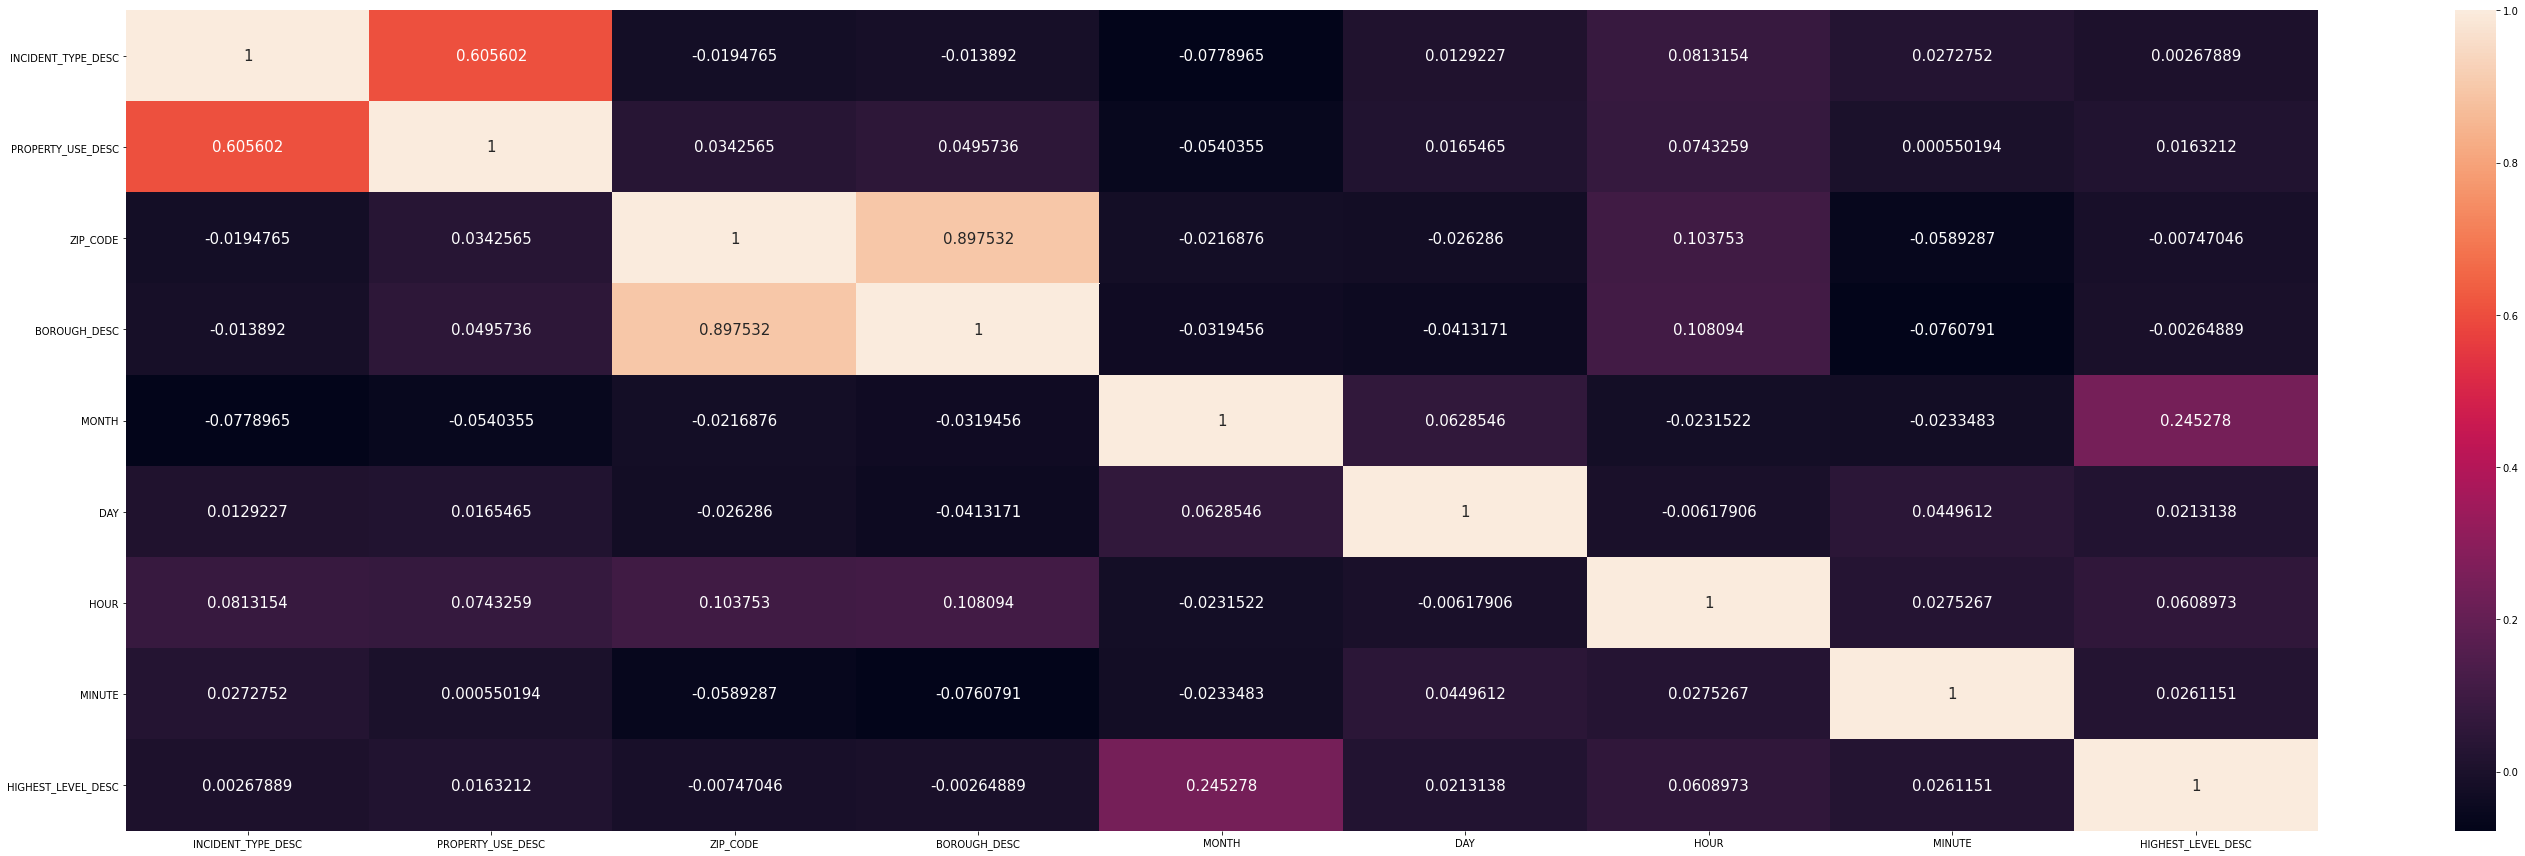

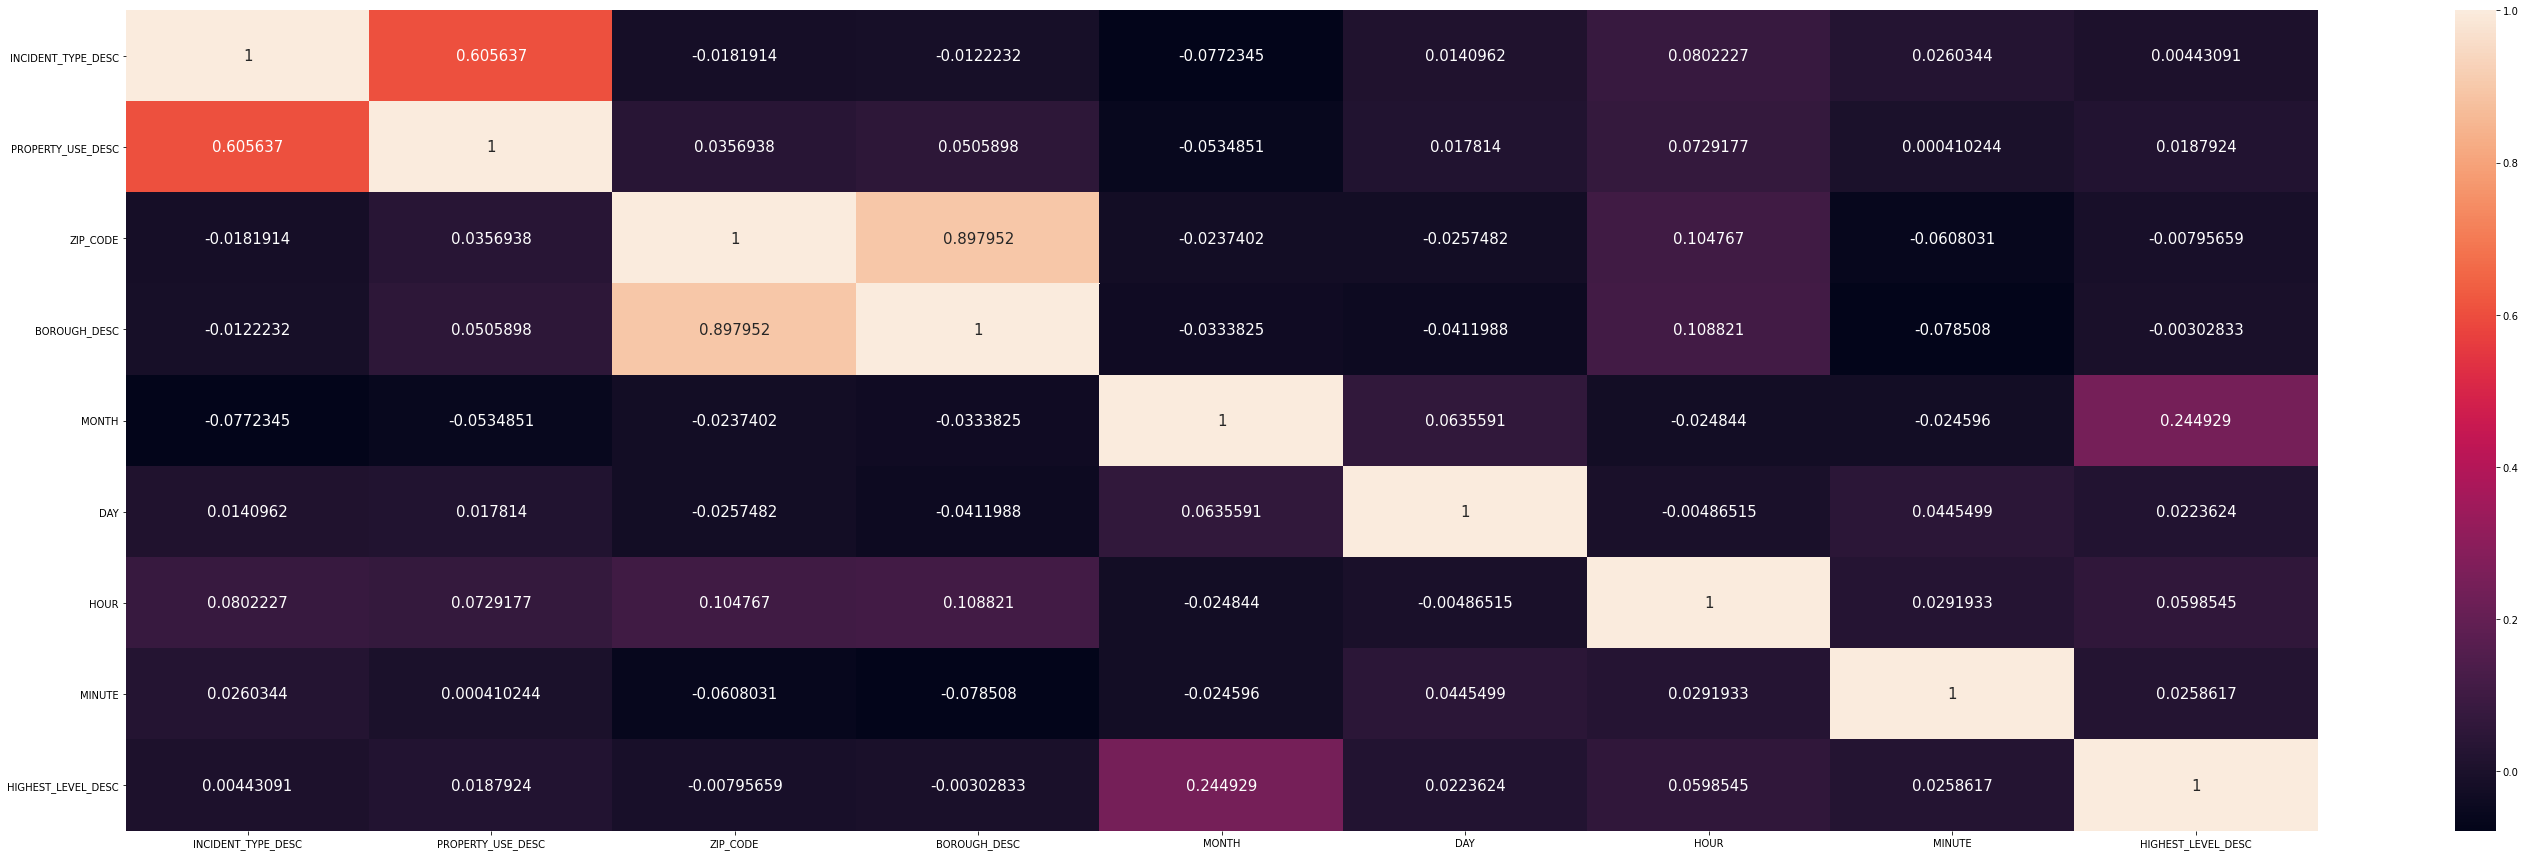

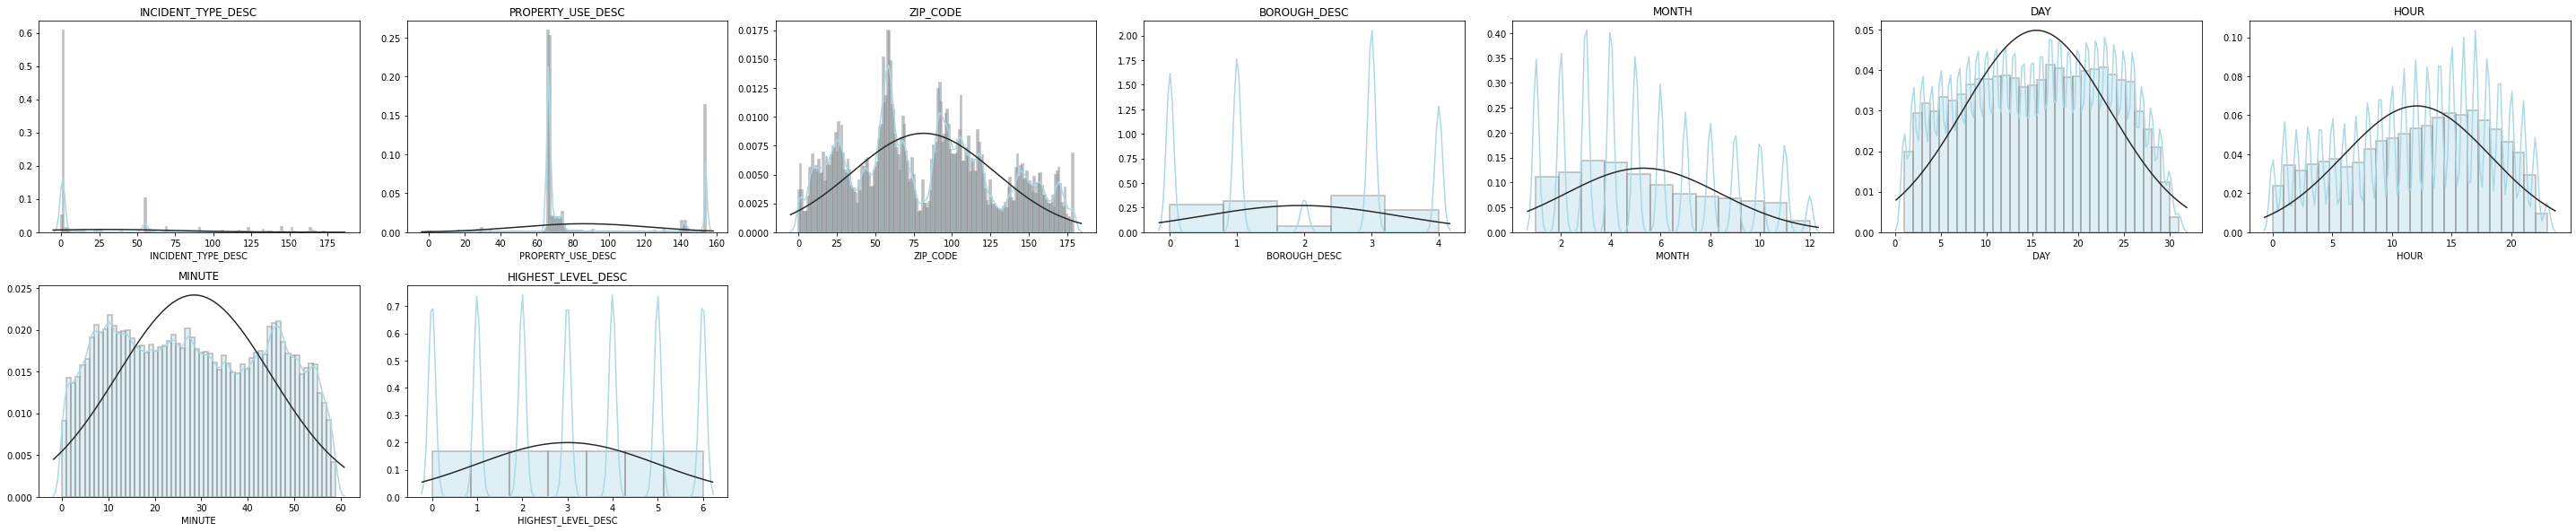

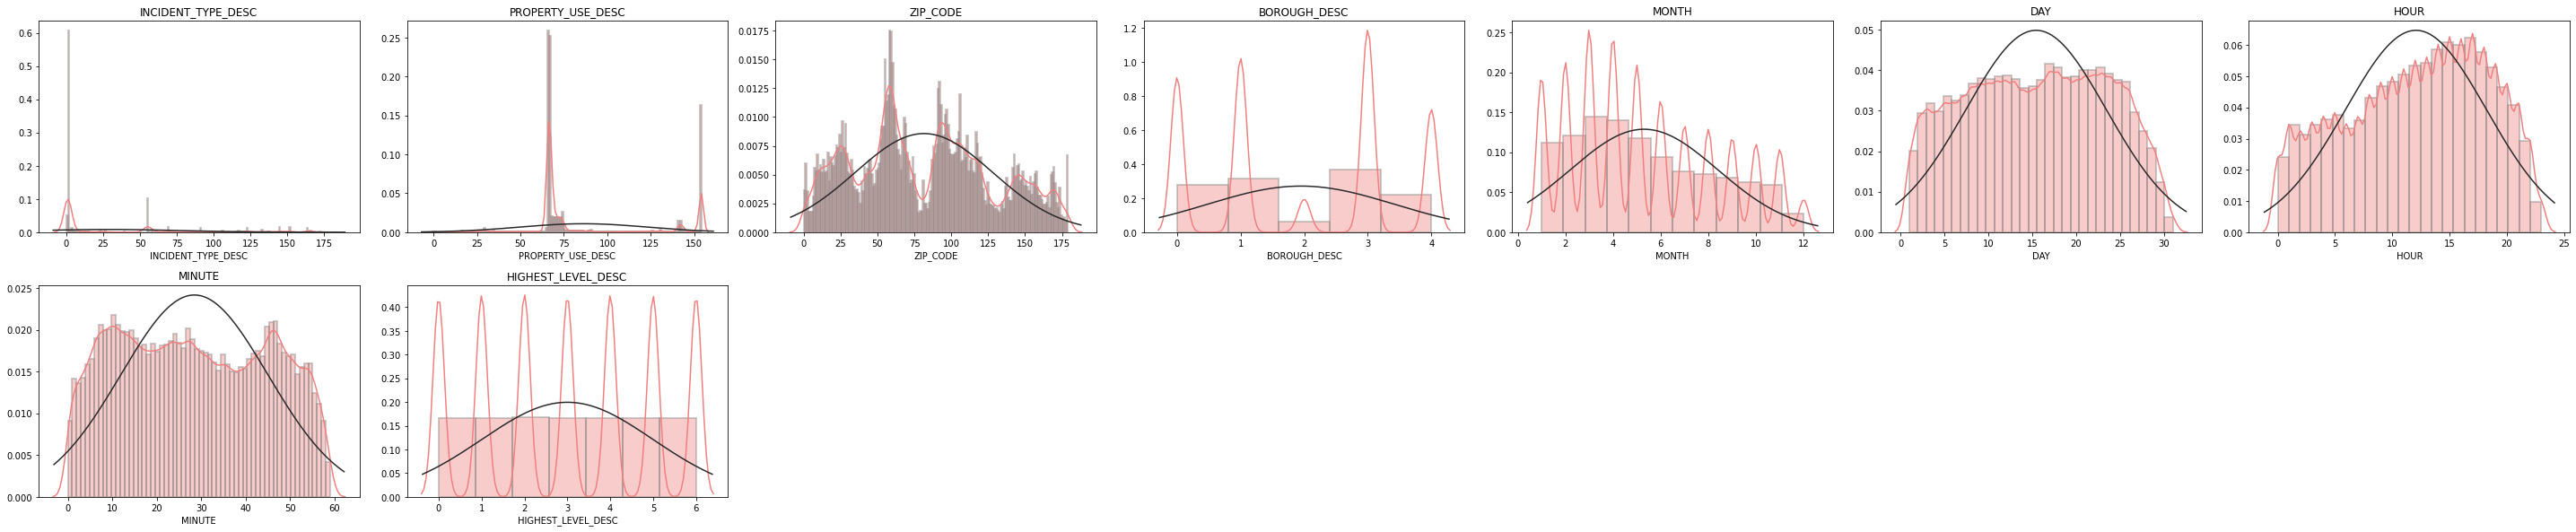

In [17]:
# creates a new csv file from the cleaned up dataset to later test the classification model
large_df.to_csv('large_df.csv')
# passes the data through the custom SMOTE function written to balance our dataset around the labels in HIGHEST_LEVEL_DESC
large_df = balance_data_SMOTE(large_df, 'HIGHEST_LEVEL_DESC')
# samples the new dataset for 1M samples with replacement
large_df_s = large_df.sample(1000000, random_state=3, replace=True)
# creates a heatmap of all of the columns to show correlation between features on the balanced dataframe
draw_heatmap(large_df)
# draws heatmap of all columns in the synthetic sampled dataframe
draw_heatmap(large_df_s)
# shows histograms for all columns in the balanced dataframe
draw_histograms(large_df, color_c='lightblue')
# shows histograms for all columns in the synthetic dataframe for comparison
draw_histograms(large_df_s, color_c='lightcoral')
# writes the new synthetic file into a csv for use in the classification model notebook 
large_df_s.to_csv('large_df_s.csv')

(3373965, 12)


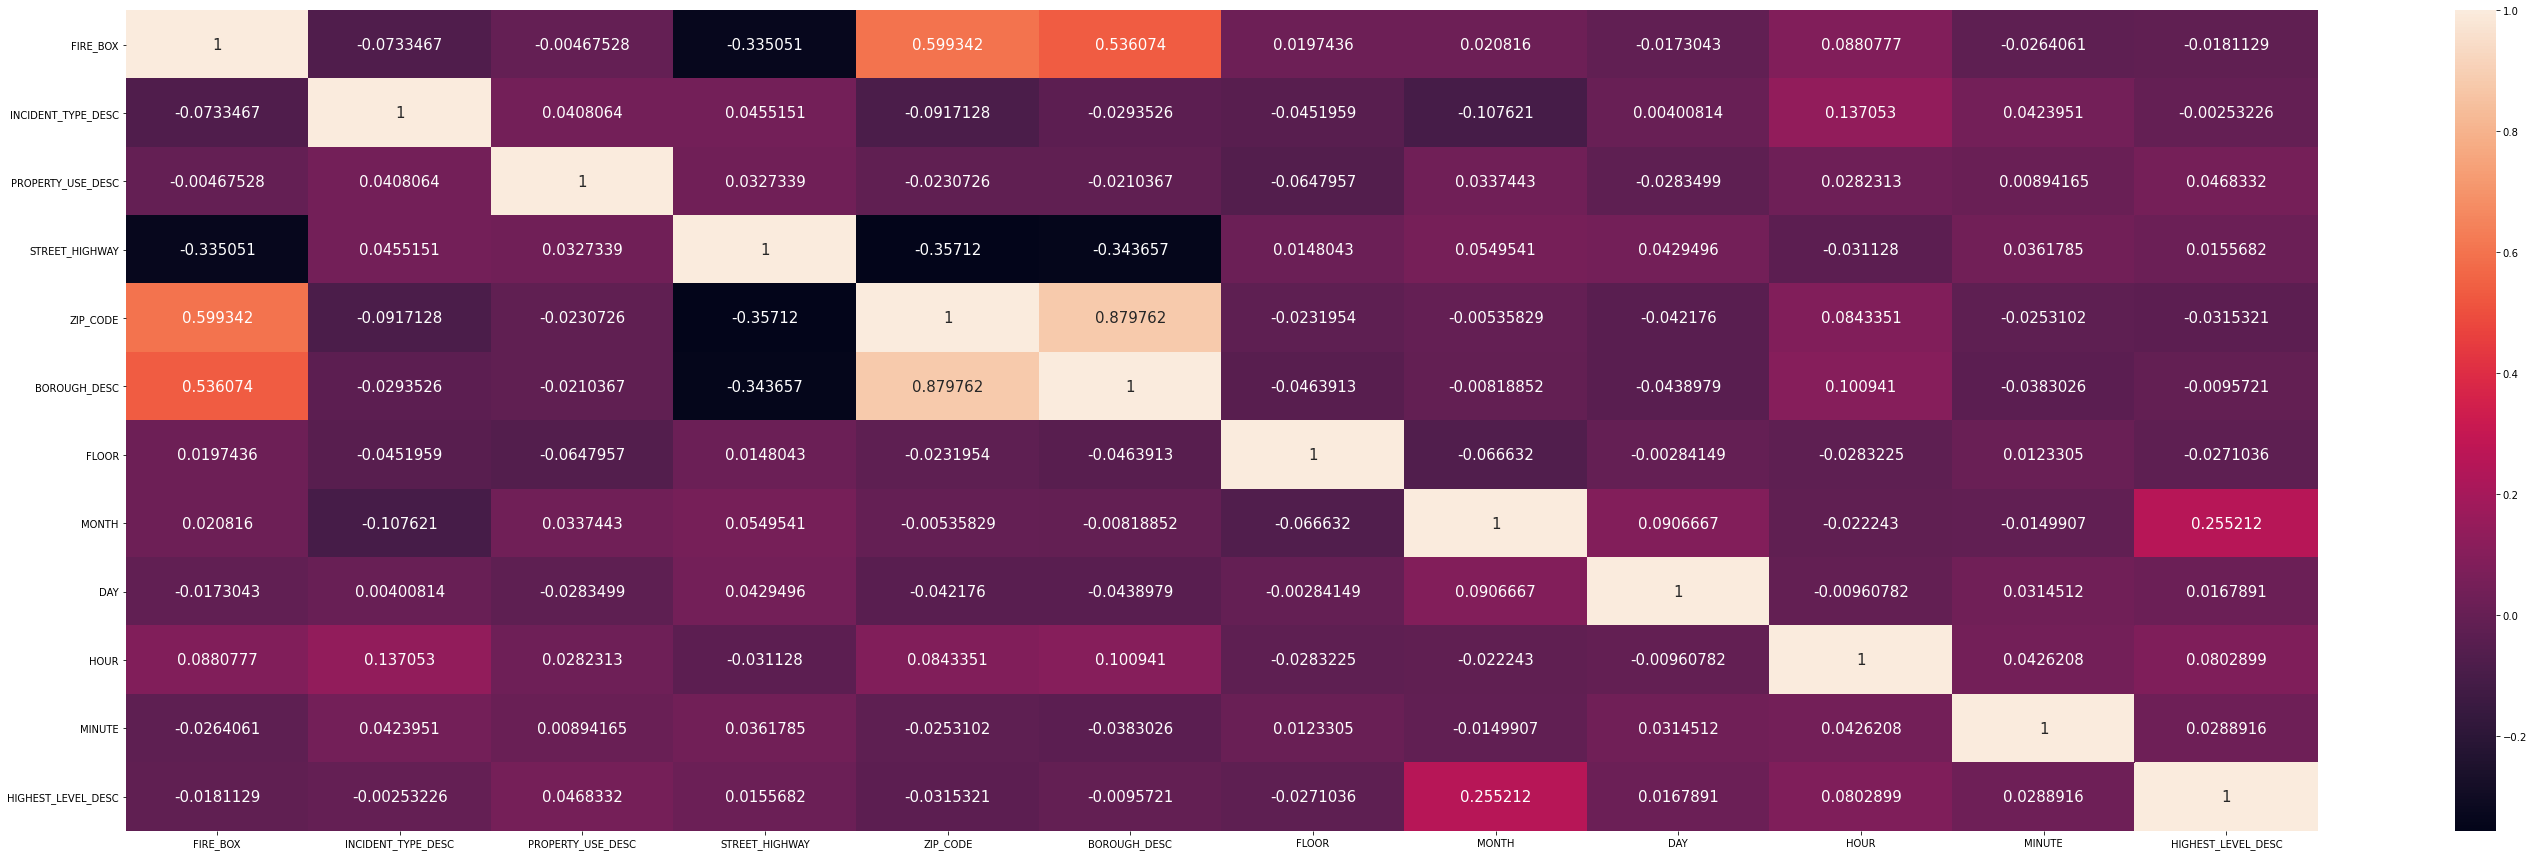

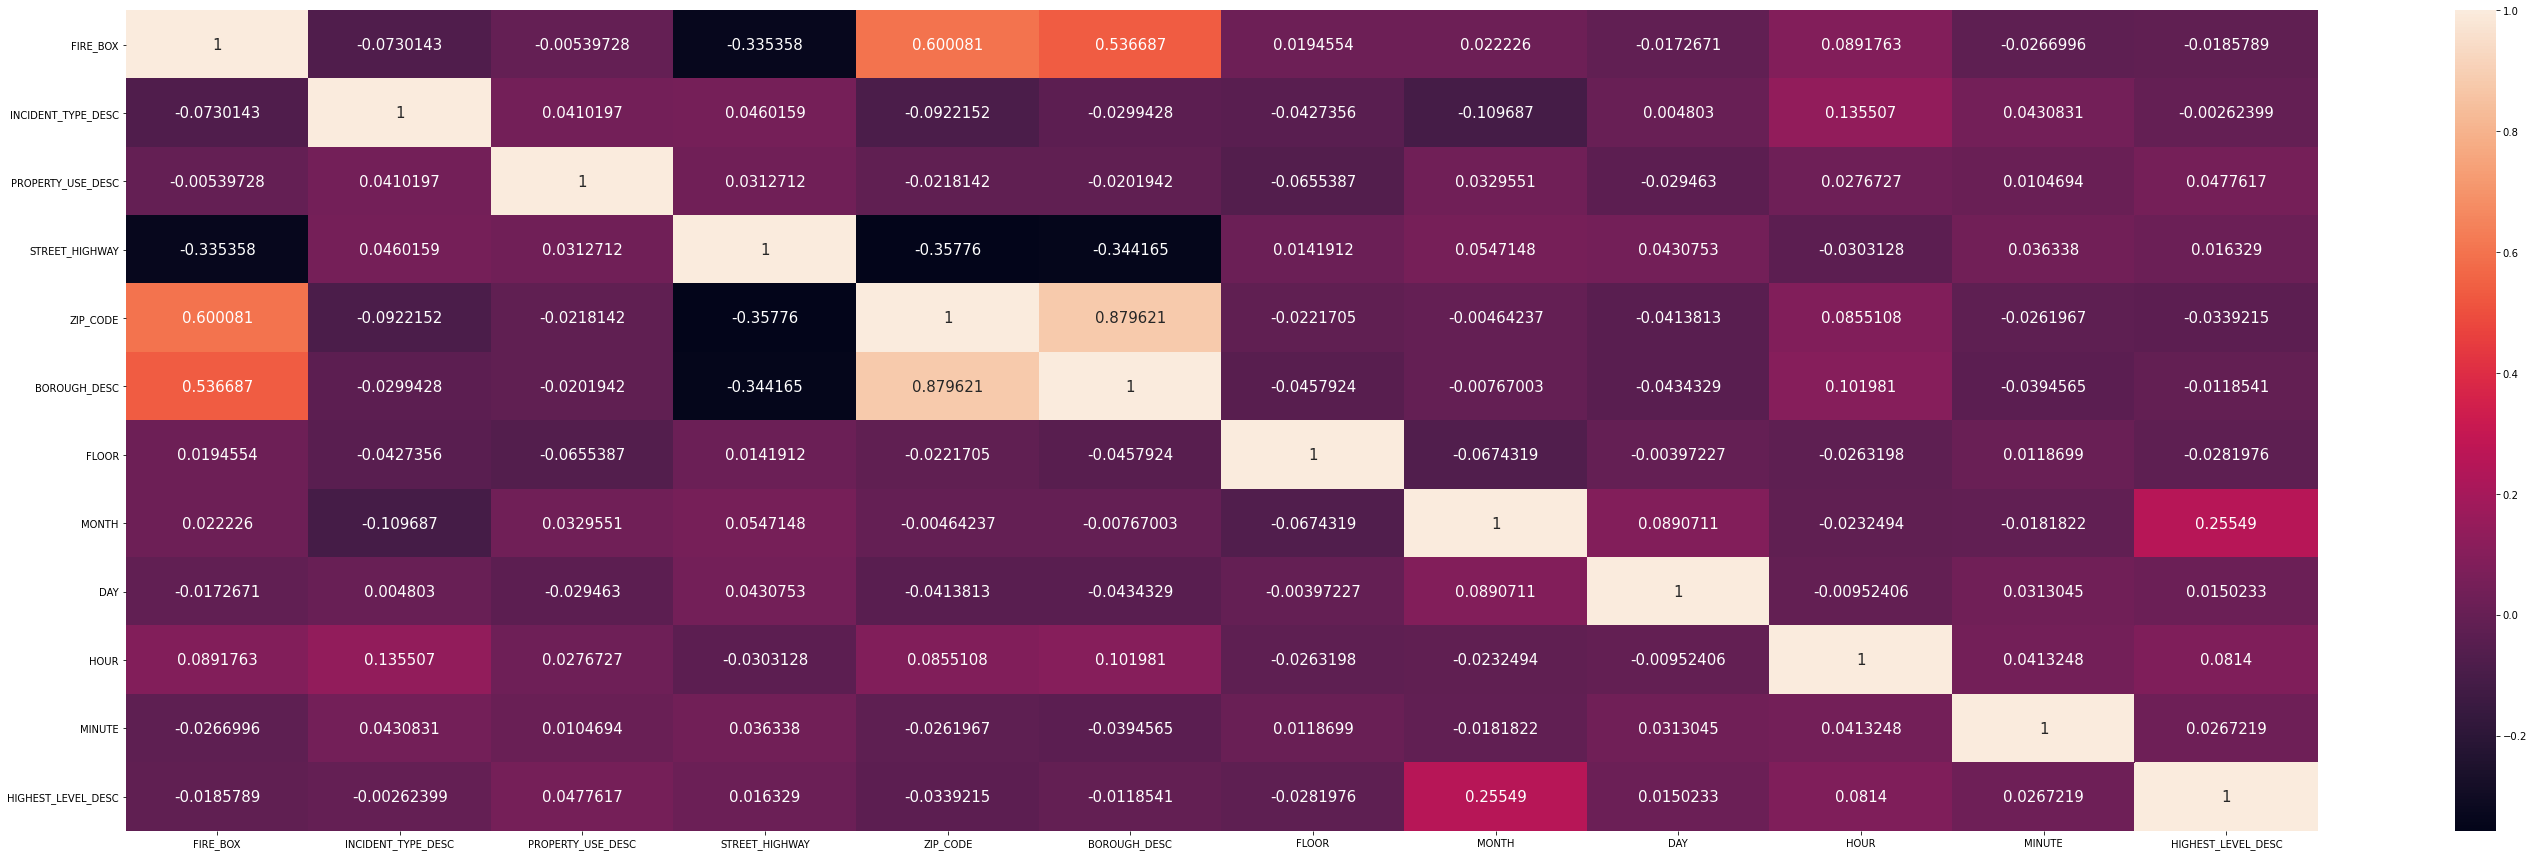

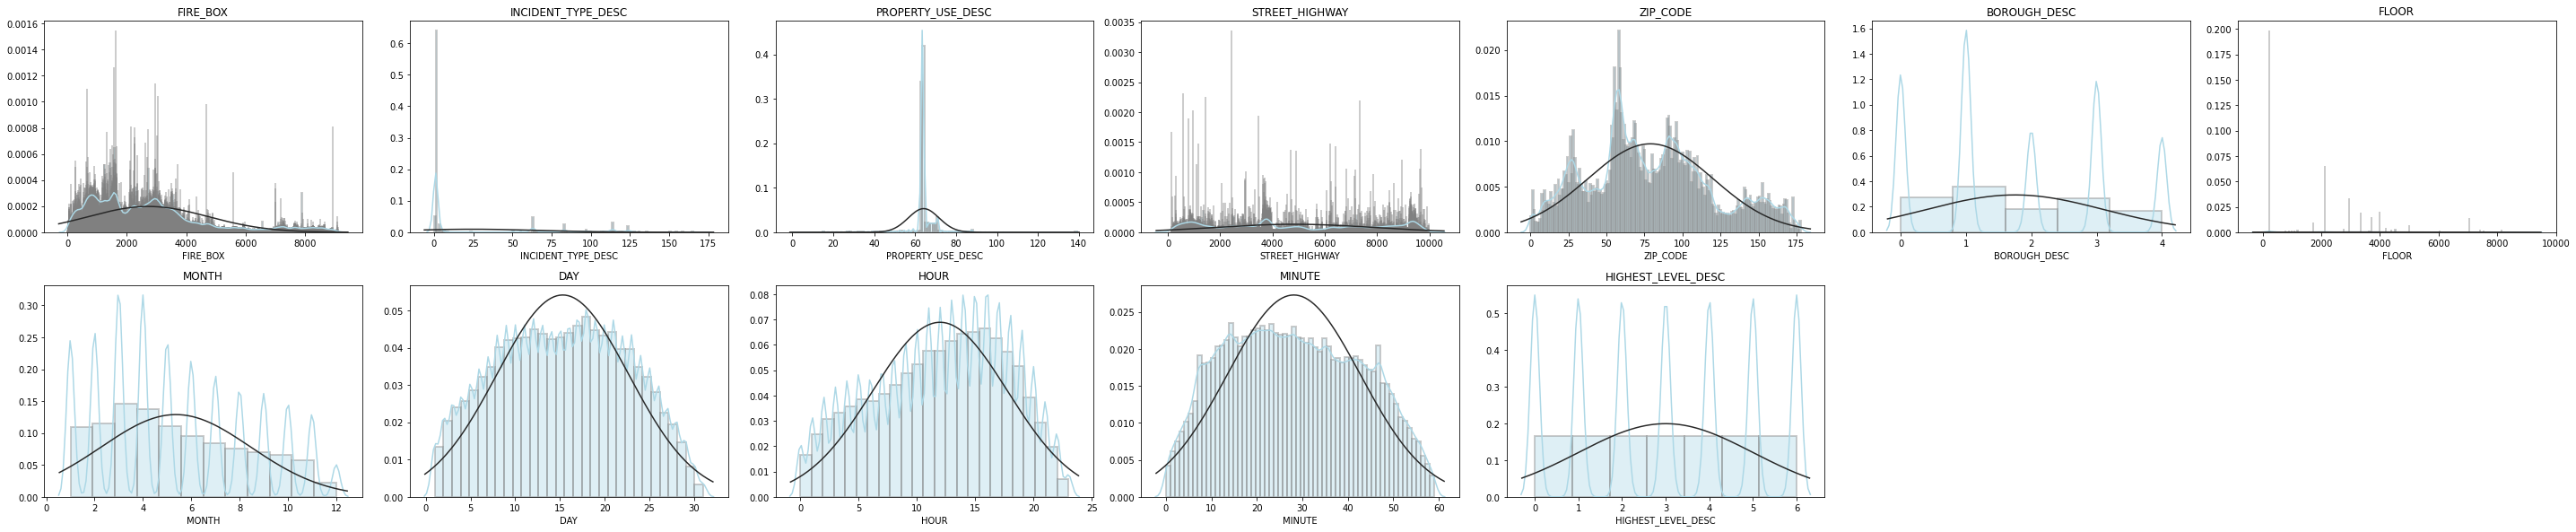

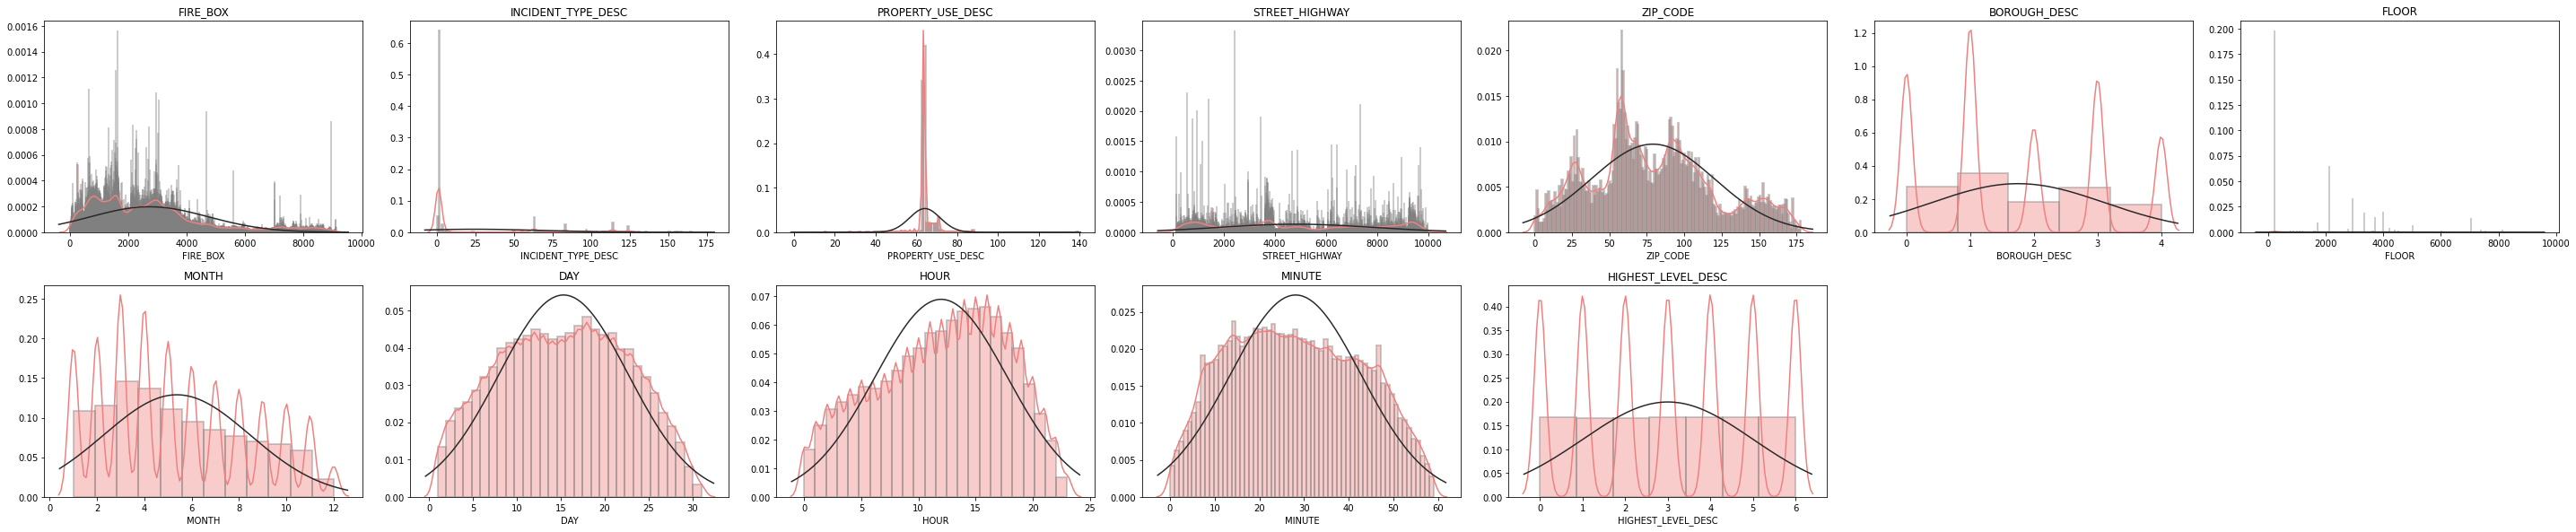

In [18]:
medium_df.to_csv('medium_df.csv')
medium_df= balance_data_SMOTE(medium_df, 'HIGHEST_LEVEL_DESC')
medium_df_s = medium_df.sample(1000000, random_state=3, replace=True)
draw_heatmap(medium_df)
draw_heatmap(medium_df_s)
draw_histograms(medium_df, color_c='lightblue')
draw_histograms(medium_df_s, color_c='lightcoral')

medium_df_s.to_csv('medium_df_s.csv')

(49672, 16)


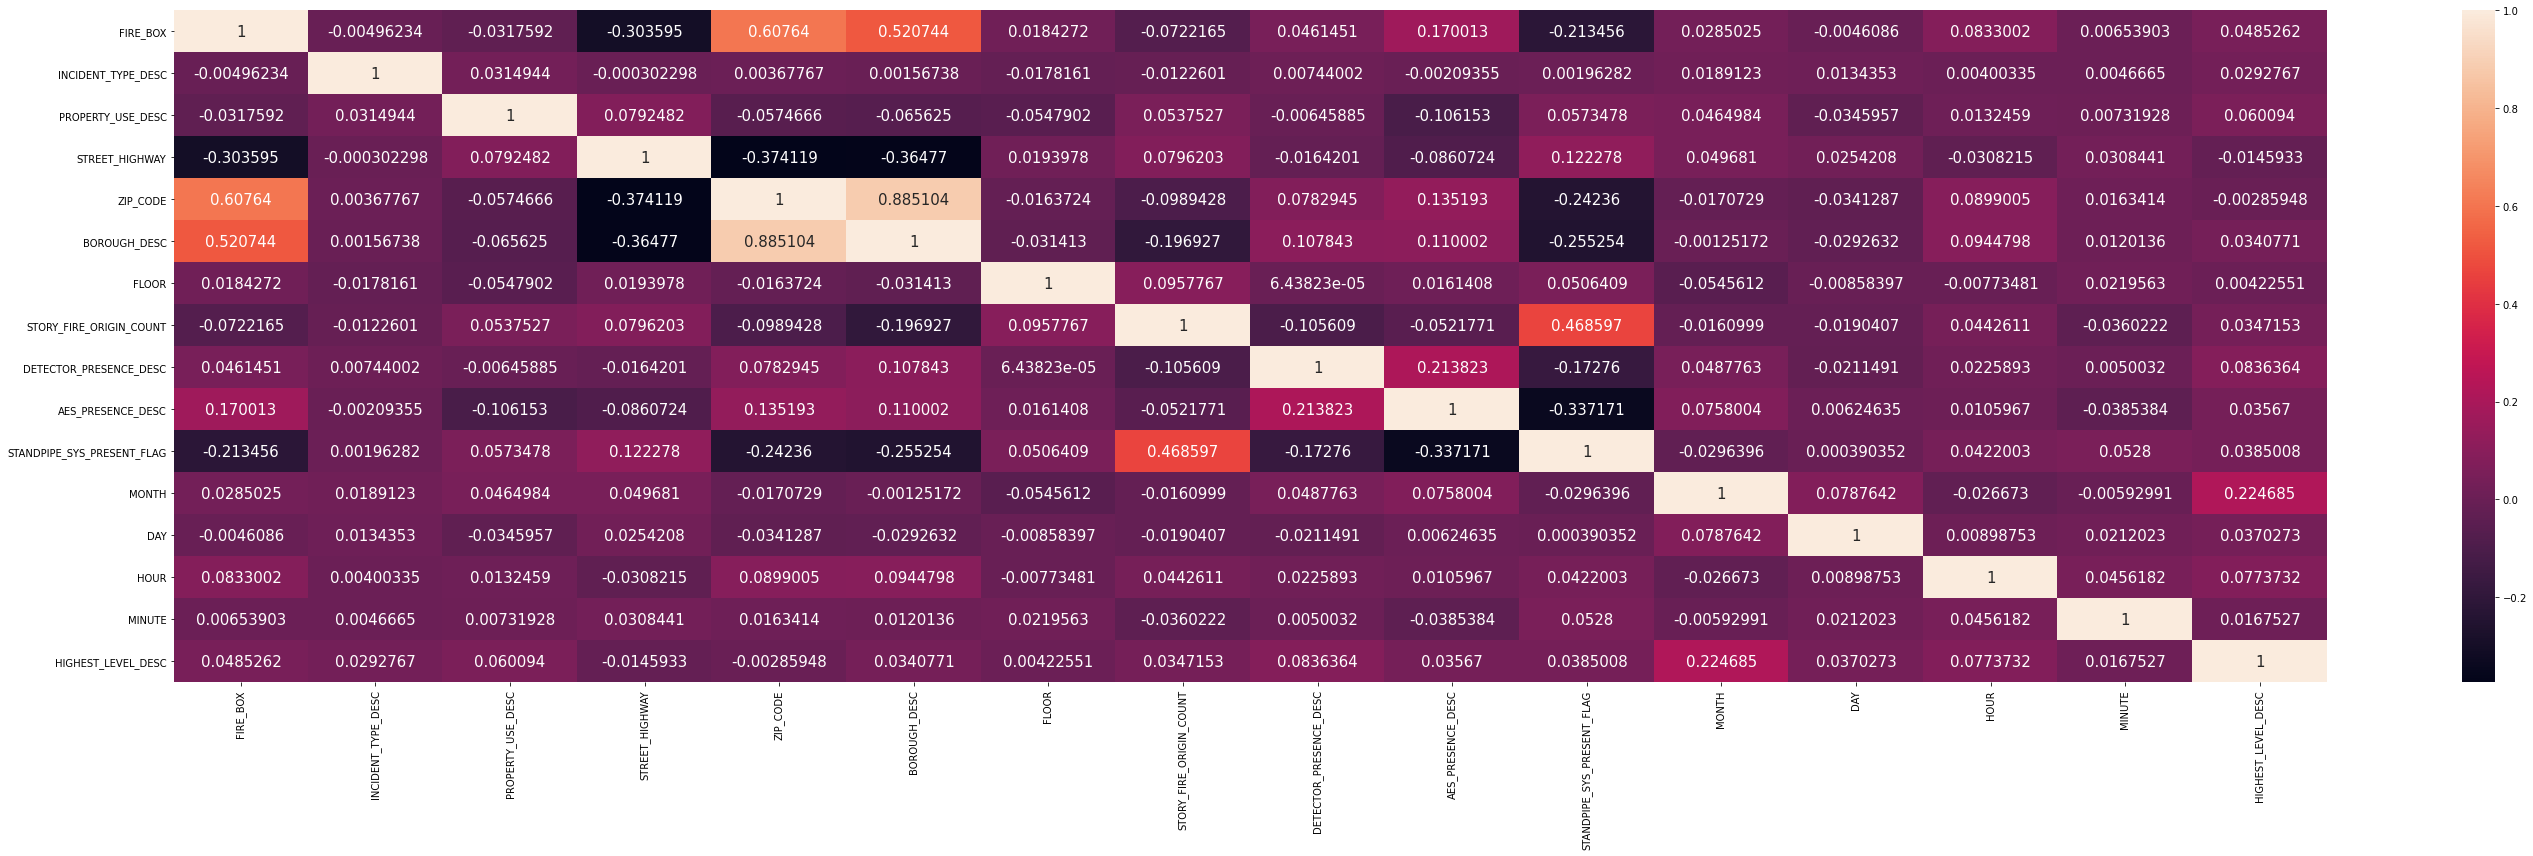

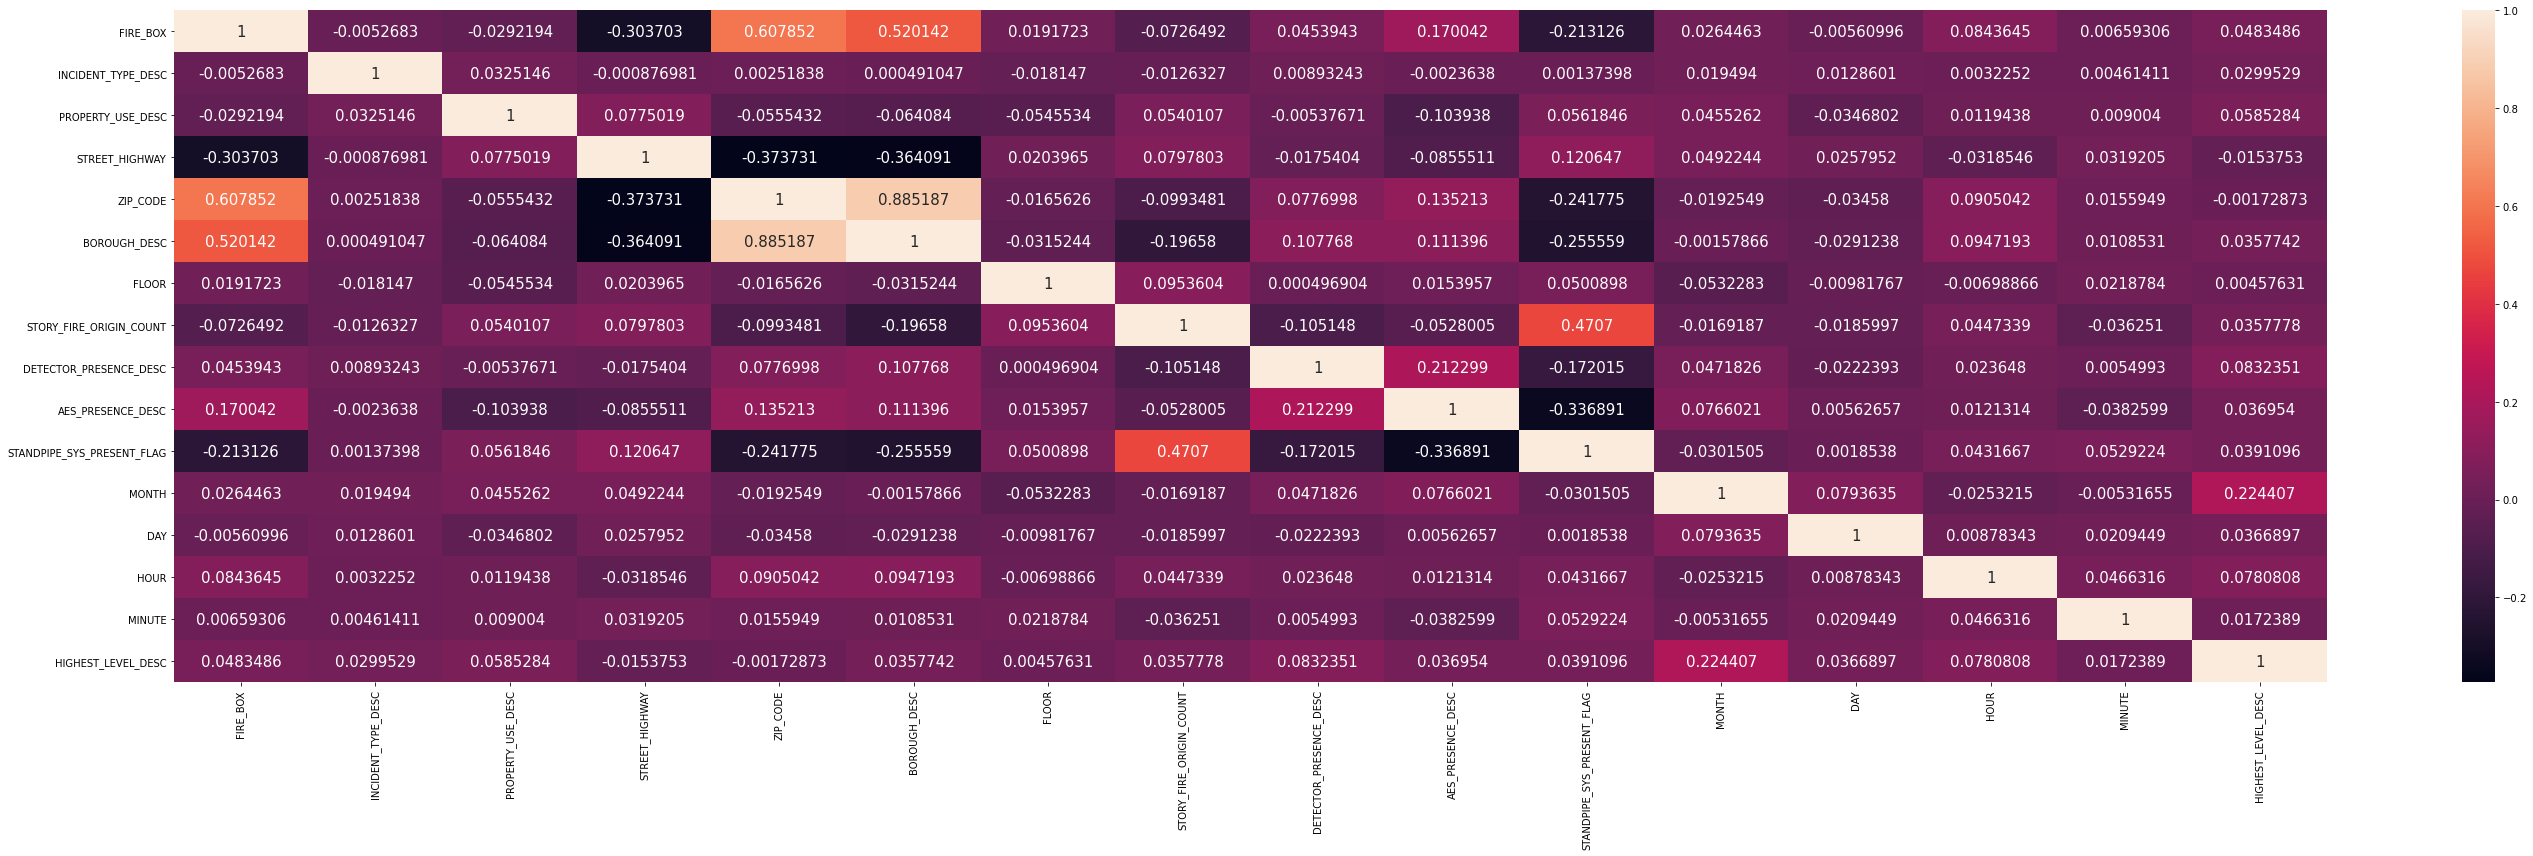

/Users/oldvasegreenbird/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/oldvasegreenbird/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/oldvasegreenbird/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/oldvasegreenbird/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/oldvasegreenbird/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarn

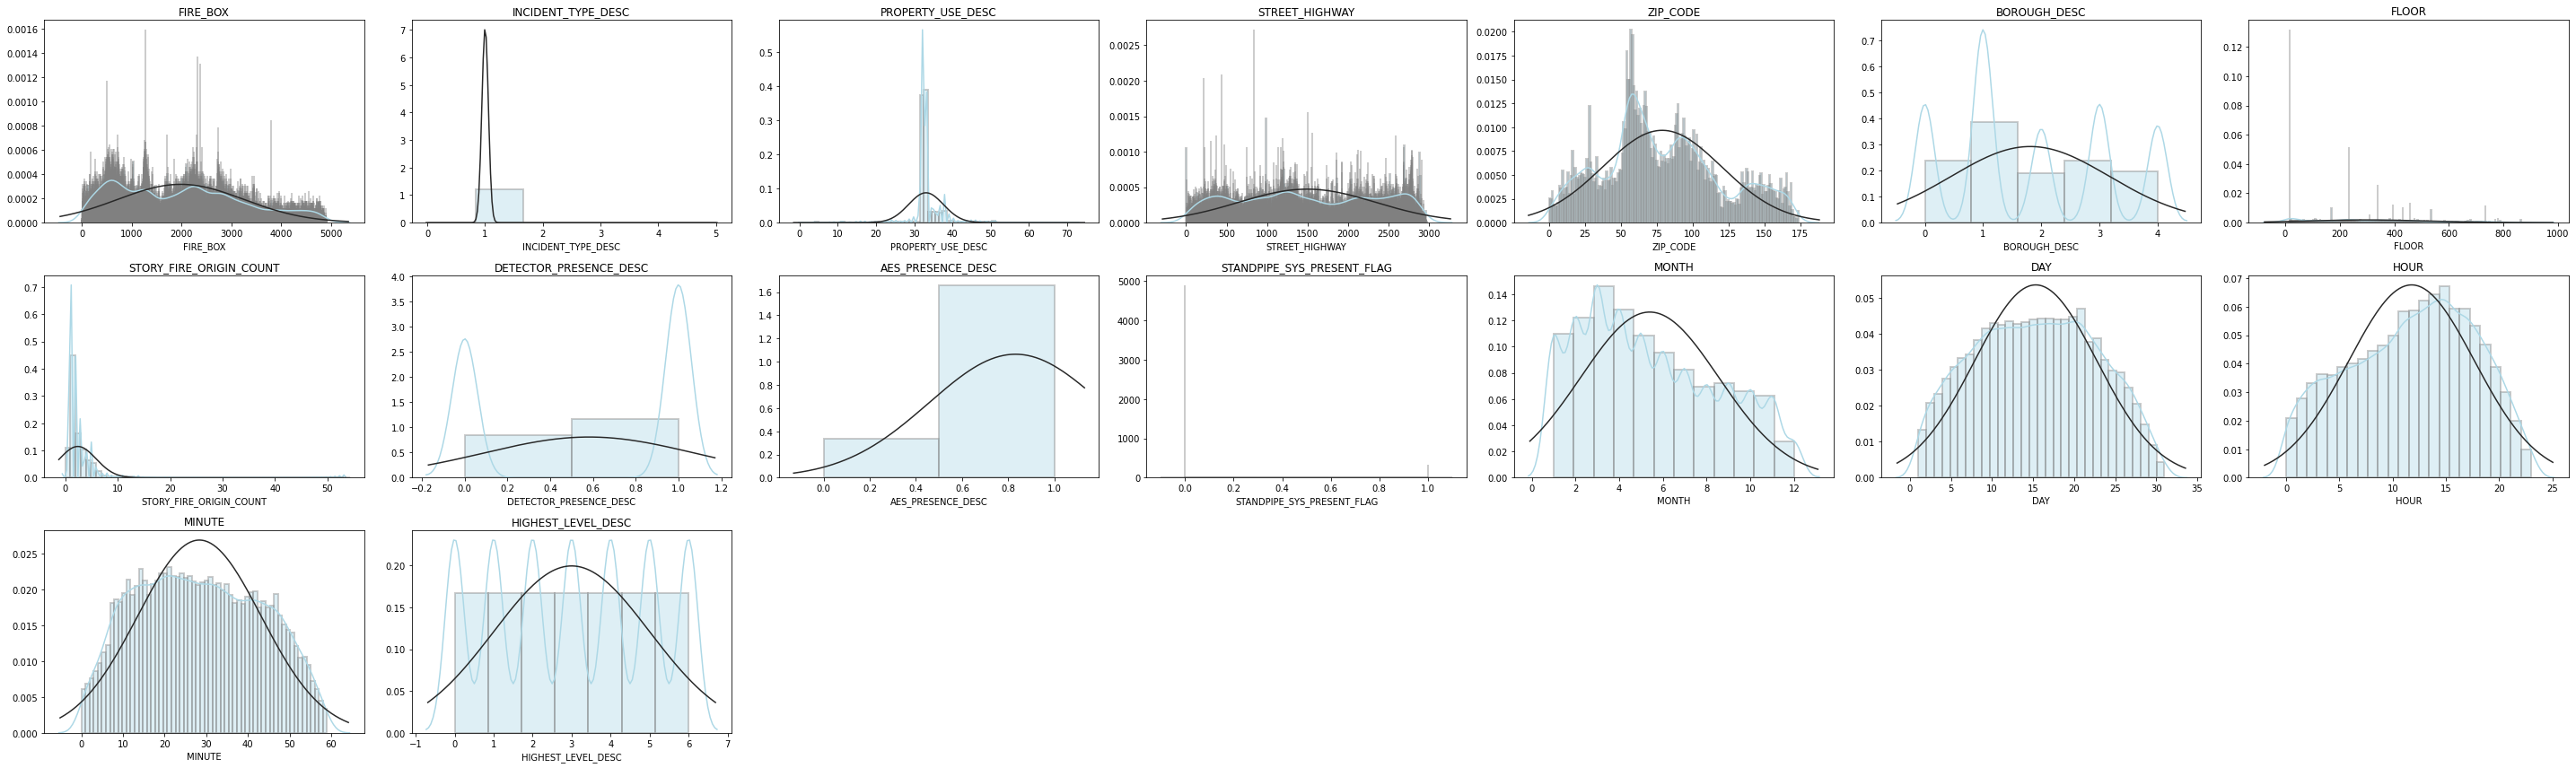

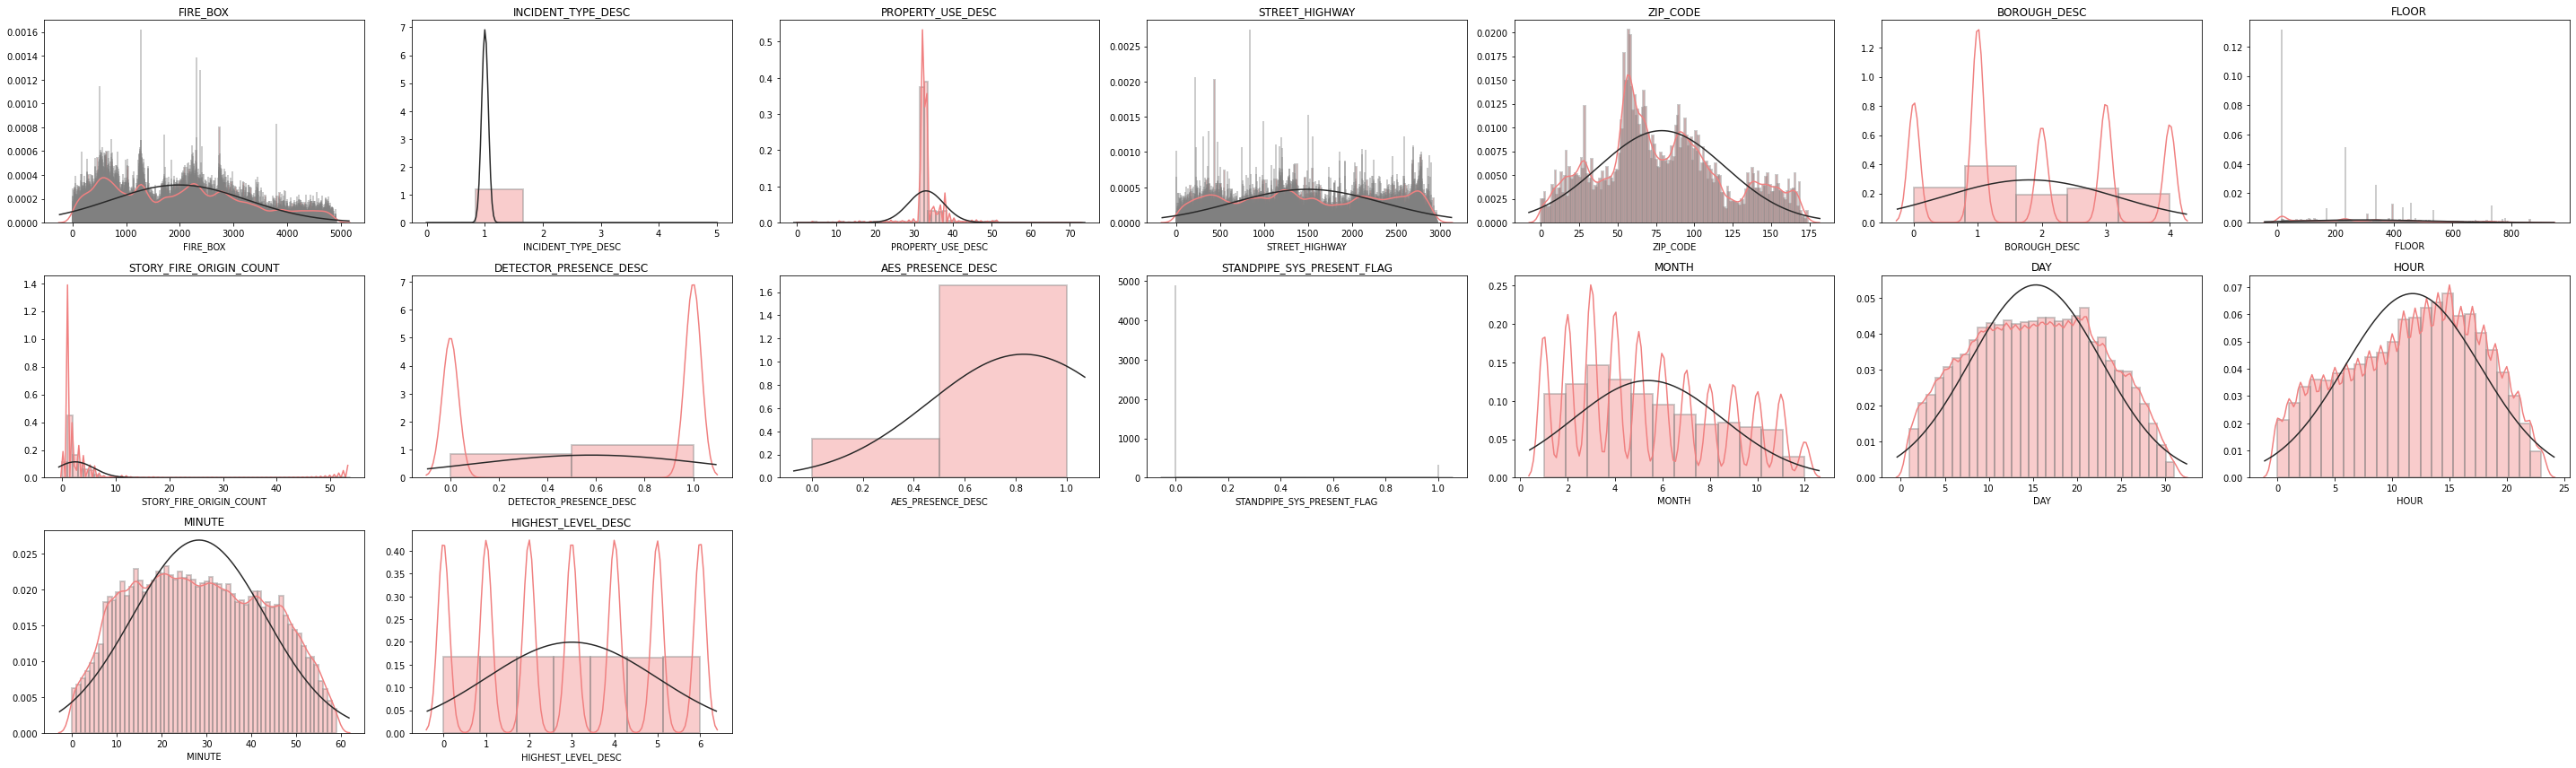

In [19]:
small_df.to_csv('small_df.csv')

small_df = balance_data_SMOTE(small_df, 'HIGHEST_LEVEL_DESC')
small_df_s = small_df.sample(1000000, random_state=3, replace=True)
draw_heatmap(small_df)
draw_heatmap(small_df_s)
draw_histograms(small_df, color_c='lightblue')
draw_histograms(small_df_s, color_c='lightcoral')

small_df_s.to_csv('small_df_s.csv')

In [20]:
print(small_df_s.shape, medium_df_s.shape, large_df_s.shape)

(1000000, 16) (1000000, 12) (1000000, 9)


In [21]:
# describe 

small_df_s

,FIRE_BOX,INCIDENT_TYPE_DESC,PROPERTY_USE_DESC,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,FLOOR,STORY_FIRE_ORIGIN_COUNT,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG,MONTH,DAY,HOUR,MINUTE,HIGHEST_LEVEL_DESC
5994,3359,1,32,81,124,4,16,1,1,1,0.000000,11,5,10,54,5
1688,3941,1,33,11,154,4,733,0,1,1,0.000000,11,1,16,49,6
11513,1099,1,32,322,100,3,376,3,0,1,0.000000,2,11,9,29,0
48056,4118,1,32,85,161,4,534,0,1,1,0.000000,5,25,11,29,6
25544,1268,1,33,2545,85,2,340,3,0,1,0.000000,5,10,10,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30154,3309,1,32,321,127,4,363,2,1,1,0.000000,4,17,11,39,2
38129,624,1,21,2869,74,2,341,4,0,0,0.783278,3,15,5,19,3
37215,2928,1,36,2447,77,2,34,0,1,1,0.000000,10,26,6,23,3
19692,376,1,33,844,11,0,16,1,0,1,0.000000,10,14,18,7,1


In [22]:
medium_df_s.describe()

,FIRE_BOX,INCIDENT_TYPE_DESC,PROPERTY_USE_DESC,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,FLOOR,MONTH,DAY,HOUR,MINUTE,HIGHEST_LEVEL_DESC
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2723.073333,24.282397,64.209581,4828.968451,79.029015,1.751838,2674.096961,5.372271,15.315024,11.978621,28.135756,3.002600
std,2019.197523,41.754384,7.500466,3010.258121,41.141416,1.363833,2248.628621,3.094603,7.362764,5.787218,14.629518,2.000104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1205.000000,1.000000,63.000000,2207.000000,53.000000,1.000000,388.750000,3.000000,9.000000,8.000000,16.000000,1.000000
50%,2351.000000,1.000000,64.000000,4316.000000,74.000000,1.000000,2140.000000,5.000000,15.000000,13.000000,28.000000,3.000000
75%,3532.000000,40.000000,64.000000,7651.000000,105.000000,3.000000,3945.000000,8.000000,21.000000,17.000000,40.000000,5.000000
max,9157.000000,172.000000,139.000000,10106.000000,178.000000,4.000000,9154.000000,12.000000,31.000000,23.000000,59.000000,6.000000


In [23]:
large_df_s.describe()

,INCIDENT_TYPE_DESC,PROPERTY_USE_DESC,ZIP_CODE,BOROUGH_DESC,MONTH,DAY,HOUR,MINUTE,HIGHEST_LEVEL_DESC
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,28.325602,86.231882,81.472867,1.948707,5.301552,15.441272,12.073677,28.458314,3.000231
std,47.707652,36.493419,46.574302,1.469709,3.096859,8.004734,6.160801,16.509005,1.998345
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,66.000000,46.000000,1.000000,3.000000,9.000000,7.000000,14.000000,1.000000
50%,1.000000,67.000000,76.000000,2.000000,5.000000,16.000000,13.000000,28.000000,3.000000
75%,55.000000,93.000000,114.000000,3.000000,8.000000,22.000000,17.000000,43.000000,5.000000
max,180.000000,154.000000,179.000000,4.000000,12.000000,31.000000,23.000000,59.000000,6.000000
